In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa
from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import shap
# Typical tf.keras API usage
import tensorflow as tf

In [ ]:
# load the whole dataset, for data info
all_ds   = tfds.load("eurosat/all", with_info=True)
# load training, testing & validation sets, splitting by 60%, 20% and 20% respectively
train_ds = tfds.load("eurosat/all", split="train[:95%]")
# test_ds  = tfds.load("eurosat/all", split="train[90%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/eurosat/all/2.0.0.incompleteYYW6R2/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/all/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# the class names
class_names = all_ds[1].features["label"].names
# total number of classes (10)
num_classes = len(class_names)
num_examples = all_ds[1].splits["train"].num_examples

In [ ]:
# number of testing steps
n_training_steps = int(all_ds[1].splits["train"].num_examples * 0.95)

# get all testing images as NumPy array
images = np.array([ d["sentinel2"] for d in train_ds.take(n_training_steps) ])
print("images.shape:", images.shape)

# get all testing labels as NumPy array
labels = np.array([ d["label"] for d in train_ds.take(n_training_steps) ])
print("labels.shape:", labels.shape)

images.shape: (25650, 64, 64, 13)
labels.shape: (25650,)


In [ ]:
ind_train = []
min_percent = 1   # Low percentile
max_percent = 99  # High percentile

for i in range(0,images.shape[0]):
  image1 = images[i]

  red_raw = image1[:,:,3]
  lo_red_raw, hi_red_raw = np.percentile(red_raw, (min_percent, max_percent))
  # Apply linear "stretch" - lo goes to 0, and hi goes to 1
  res_img_red = (red_raw.astype(float) - lo_red_raw) / (hi_red_raw-lo_red_raw)

  red = (res_img_red - res_img_red.min()) /(res_img_red.max() - res_img_red.min())
  # red = np.uint8((red_raw /(red_raw.max()))*255)
  # print(red.min(), red.max())

  nir_raw = image1[:,:,7]

  lo_nir_raw, hi_nir_raw = np.percentile(nir_raw, (min_percent, max_percent))
  # Apply linear "stretch" - lo goes to 0, and hi goes to 1
  res_img_nir = (nir_raw.astype(float) - lo_nir_raw) / (hi_nir_raw-lo_nir_raw)
  nir = (res_img_nir - res_img_nir.min()) /(res_img_nir.max() - res_img_nir.min())

  # swir1_raw = image1[:,:,12]
  # swir1 = swir1_raw/swir1_raw.max()
  # # swir1 = np.uint8(((swir1_raw/swir1_raw.max()))*255)
  # #print(swir1.min(), swir1.max())

  green_raw = image1[:,:,2]

  lo_green_raw, hi_green_raw = np.percentile(green_raw, (min_percent, max_percent))
  # Apply linear "stretch" - lo goes to 0, and hi goes to 1
  res_img_green = (green_raw.astype(float) - lo_green_raw) / (hi_green_raw-lo_green_raw)
  green = (res_img_green - res_img_green.min()) /(res_img_green.max() - res_img_green.min())

  # green = np.uint8(((green_raw/(green_raw.max())))*255)
  #print(green.min(), green.max())

  # bleu_raw = image1[:,:,1]
  # bleu = bleu_raw/(bleu_raw.max())
  # bleu = np.uint8(((bleu_raw/(bleu_raw.max())))*255)
  #print(bleu.min(), bleu.max())
  #print("")
  # ndvi = (nir - red)/(nir + red)
  # #print(ndvi.min(), ndvi.max())

  # ndwi = (green - nir)/(green+nir)
  # #print(ndwi.min(), ndwi.max())

  # ndbi = (swir1 - nir)/(swir1+nir)
  # #print(ndbi.min(), ndbi.max())

  st_indices = np.stack([nir, red, green], axis=2)

  #st_indices2 = np.uint8(st_indices1*127.5)

  ind_train.append(st_indices)

INDICIES = np.array(ind_train)
print('INDICIES shape:', INDICIES.shape)
print('INDICIES shape:', INDICIES.dtype)

INDICIES shape: (25650, 64, 64, 3)
INDICIES shape: float64


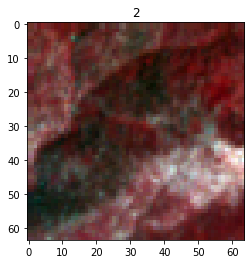

In [ ]:
img = Image.fromarray(np.uint8(INDICIES[40]*255), mode = "RGB")
plt.title(labels[40])
plt.imshow(img)

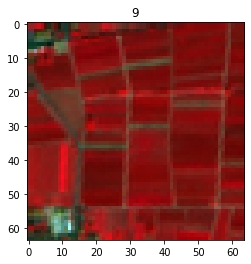

In [ ]:
img = Image.fromarray(np.uint8(INDICIES[51]*255), mode = "RGB")
plt.title(labels[50])
plt.imshow(img)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(INDICIES, labels, test_size=0.20, random_state=42, shuffle = True)

In [ ]:
print(X_train.shape)
print(X_train.dtype)

print(y_train.shape)
print(y_train.dtype)

print(X_test.shape)
print(X_test.dtype)

print(y_test.shape)
print(y_test.dtype)

(20520, 64, 64, 3)
float64
(20520,)
int64
(5130, 64, 64, 3)
float64
(5130,)
int64


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(64,
                                  64,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
filters = 16
model = Sequential([
  data_augmentation,

  layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal', activation=tfa.activations.gelu),
  # layers.BatchNormalization(),
  layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal', activation=tfa.activations.gelu),
  # layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(2*filters, 3, padding='same', kernel_initializer='he_normal', activation=tfa.activations.gelu),
  # layers.BatchNormalization(),
  layers.Conv2D(2*filters, 3, padding='same', kernel_initializer='he_normal', activation=tfa.activations.gelu),
  # layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(4*filters, 3, padding='same', kernel_initializer='he_normal', activation=tfa.activations.gelu),
  # layers.BatchNormalization(),
  layers.Conv2D(4*filters, 3, padding='same', kernel_initializer='he_normal', activation=tfa.activations.gelu),
  # layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(8*filters, 3, padding='same', kernel_initializer='he_normal', activation=tfa.activations.gelu),
  # layers.BatchNormalization(),
  layers.Conv2D(8*filters, 3, padding='same', kernel_initializer='he_normal', activation=tfa.activations.gelu),
  # layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(16*filters, 3, padding='same', kernel_initializer='he_normal', activation=tfa.activations.gelu),
  # layers.BatchNormalization(),
  layers.Conv2D(16*filters, 3, padding='same', kernel_initializer='he_normal', activation=tfa.activations.gelu),
  # layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(32*filters, activation=tfa.activations.gelu),
  layers.Dropout(0.1),
  layers.Dense(16*filters, activation=tfa.activations.gelu),
  layers.Dropout(0.2),
  layers.Dense(8*filters, activation=tfa.activations.gelu),
  layers.Dropout(0.3),
  layers.Dense(num_classes, activation = "softmax")
])

model.compile(optimizer=tfa.optimizers.LAMB(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                      

In [ ]:
# fiting the model
epochs = 100

# Callback options for preventing overfitting (earlystopping)
callbacksOptions = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001, verbose=1),

    # save best only result
    keras.callbacks.ModelCheckpoint('covid_19_checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:

history = model.fit(
  X_train, y_train,
  validation_split=0.10,
  epochs=epochs,
  callbacks=callbacksOptions,
  batch_size = 64
)

Train on 18468 samples, validate on 2052 samples
Epoch 1/100
18468/18468 [==============================] - ETA: 0s - loss: 1.6736 - acc: 0.3944

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



Epoch 1: val_loss improved from inf to 1.16323, saving model to covid_19_checkpoint.h5
18468/18468 [==============================] - 18s 979us/sample - loss: 1.6736 - acc: 0.3944 - val_loss: 1.1632 - val_acc: 0.6077 - lr: 0.0010
Epoch 2/100
18432/18468 [============================>.] - ETA: 0s - loss: 1.0344 - acc: 0.6413
Epoch 2: val_loss improved from 1.16323 to 0.83789, saving model to covid_19_checkpoint.h5
18468/18468 [==============================] - 16s 875us/sample - loss: 1.0345 - acc: 0.6412 - val_loss: 0.8379 - val_acc: 0.6925 - lr: 0.0010
Epoch 3/100
18432/18468 [============================>.] - ETA: 0s - loss: 0.8350 - acc: 0.7119
Epoch 3: val_loss improved from 0.83789 to 0.73958, saving model to covid_19_checkpoint.h5
18468/18468 [==============================] - 16s 866us/sample - loss: 0.8351 - acc: 0.7119 - val_loss: 0.7396 - val_acc: 0.7364 - lr: 0.0010
Epoch 4/100
18432/18468 [============================>.] - ETA: 0s - loss: 0.7212 - acc: 0.7528
Epoch 4: val_

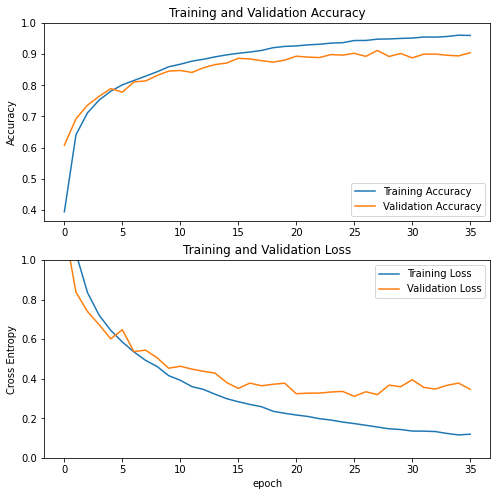

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [ ]:
# feed the images to get predictions
predictions = model.predict(X_test)
# perform argmax to get class index
predictions = np.argmax(predictions, axis=1)
print("predictions.shape:", predictions.shape)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


predictions.shape: (5130,)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# root_path = "/content/drive/MyDrive/GRSL/NRG/"

Text(0.5, 69.0, 'Predicted')

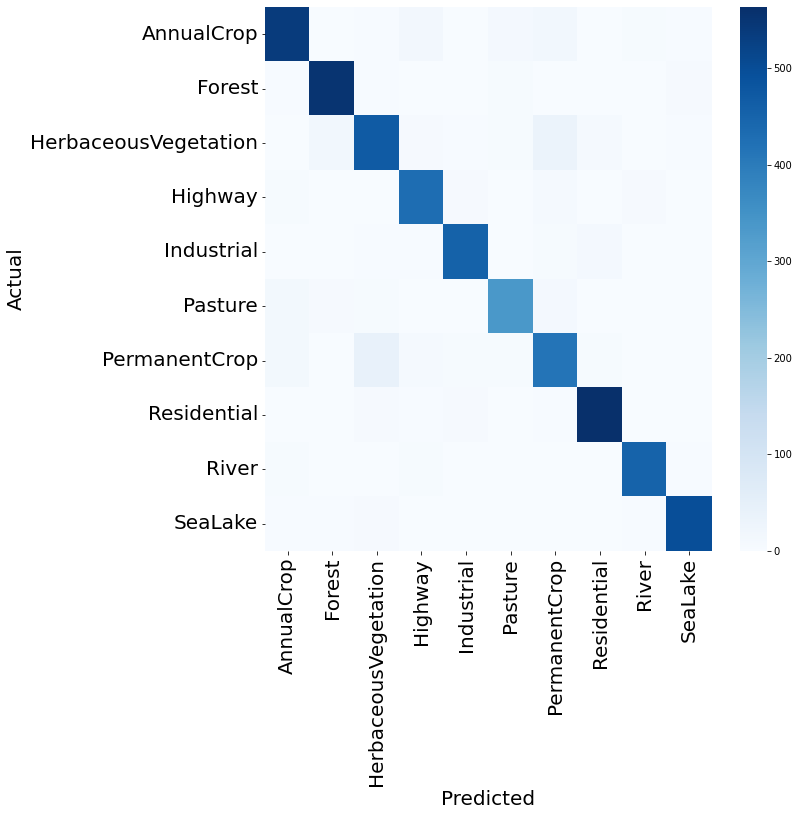

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=False, fmt='.0f',  xticklabels=[f"{c}" for c in class_names],
            yticklabels=[f"{c}" for c in class_names],
            # cmap="Blues"
            cmap="Blues")

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.xlabel('Predicted', fontsize=20)

# plt.savefig(root_path+'conf_rs_index.eps', bbox_inches='tight', format = 'eps')
# plt.savefig(root_path+'conf_rs_index.svg', bbox_inches='tight', format = 'svg')

In [ ]:
import sklearn
print("\nClassification Report :")
print(sklearn.metrics.classification_report(y_test, predictions, target_names=class_names, digits = 4))


Classification Report :
                      precision    recall  f1-score   support

          AnnualCrop     0.9133    0.9010    0.9071       596
              Forest     0.9470    0.9535    0.9503       581
HerbaceousVegetation     0.8590    0.8435    0.8512       556
             Highway     0.8977    0.9247    0.9110       465
          Industrial     0.9478    0.9458    0.9468       480
             Pasture     0.9233    0.8868    0.9047       380
       PermanentCrop     0.8297    0.8330    0.8313       497
         Residential     0.9478    0.9608    0.9542       586
               River     0.9517    0.9638    0.9577       470
             SeaLake     0.9615    0.9615    0.9615       519

            accuracy                         0.9181      5130
           macro avg     0.9179    0.9175    0.9176      5130
        weighted avg     0.9180    0.9181    0.9180      5130



In [ ]:
print(y_test[0:45])

predictions = model.predict(X_test[0:45])
predicted_class = np.argmax(predictions, axis=1)

print(predicted_class)

[2 4 3 1 2 0 7 6 5 6 2 7 6 1 6 6 6 3 4 9 2 2 7 9 3 7 6 5 2 2 7 1 1 1 8 3 7
 1 6 0 1 9 1 8 0]
[1 4 3 1 4 0 7 6 5 6 2 7 6 1 0 6 6 3 4 9 2 2 2 9 3 7 6 5 2 2 7 1 1 1 8 3 7
 1 6 0 1 9 1 8 0]


In [ ]:
# select backgroud for shap
background = X_train[np.random.choice(X_train.shape[0], 800, replace=False)]# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)# compute shap values

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



In [ ]:
for i in range(500):

  num = i
  n_num= num+1
  print(num)
  # shap_values = explainer.explainer.shap_values(X_test[num:n_num], check_additivity=False)
  shap_values = explainer.shap_values(X_test[num:n_num], check_additivity=False)
  #shap_values = explainer.shap_values(x_test_each_class)

  predictions = model.predict(X_test[num:n_num])
  predicted_class = np.argmax(predictions, axis=1)
  print("The predicted class is ", class_names[int(predicted_class)], predicted_class)
  print("The actual class is ", class_names[int(y_test[num:n_num])], y_test[num:n_num])

  plt.figure()
  # plot the feature attributions
  fig = shap.image_plot(shap_values, X_test[num:n_num], width = 25, labels= class_names, show=False)

  # # displaying the title
  # plt.savefig(root_path+str(class_names[int(predicted_class)])+'_'+str(class_names[int(y_test[num:n_num])])+'1.eps', bbox_inches='tight', format = 'eps')
  # plt.savefig(root_path+str(class_names[int(predicted_class)])+'_'+str(class_names[int(y_test[num:n_num])])+'1.svg', bbox_inches='tight', format = 'svg')

  plt.show()

The predicted class is  Highway [3]
The actual class is  Highway [3]


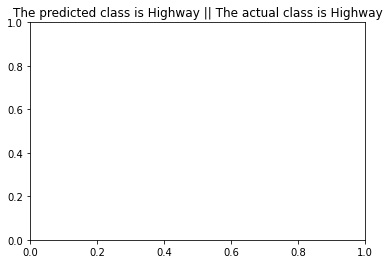

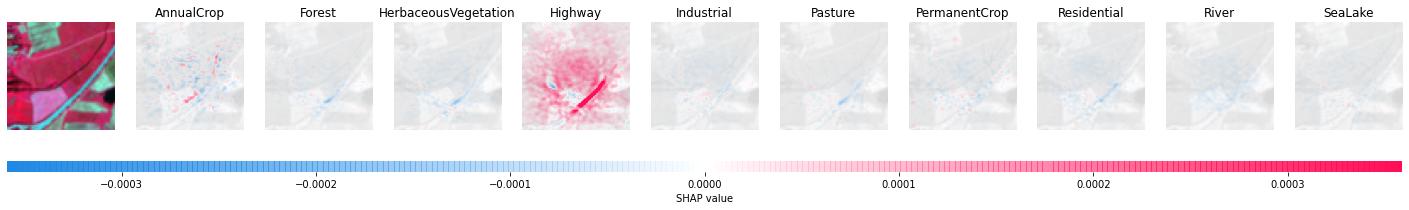

In [ ]:
num = 94
n_num= num+1

# shap_values = explainer.explainer.shap_values(X_test[num:n_num], check_additivity=False)
shap_values = explainer.shap_values(X_test[num:n_num], check_additivity=False)
#shap_values = explainer.shap_values(x_test_each_class)

predictions = model.predict(X_test[num:n_num])
predicted_class = np.argmax(predictions, axis=1)
print("The predicted class is ", class_names[int(predicted_class)], predicted_class)
print("The actual class is ", class_names[int(y_test[num:n_num])], y_test[num:n_num])

plt.title("The predicted class is "+ class_names[int(predicted_class)] + " || The actual class is "+ class_names[int(y_test[num:n_num])])

# plot the feature attributions
fig = shap.image_plot(shap_values, X_test[num:n_num], width = 25, labels= class_names, show=False)
# plt.figure()

# # displaying the title
# plt.savefig(root_path+str(class_names[int(predicted_class)])+'_'+str(class_names[int(y_test[num:n_num])])+'1.eps', bbox_inches='tight', format = 'eps')
plt.savefig(str(class_names[int(predicted_class)])+'_'+str(class_names[int(y_test[num:n_num])])+'1.svg', bbox_inches='tight', format = 'svg')

plt.show()

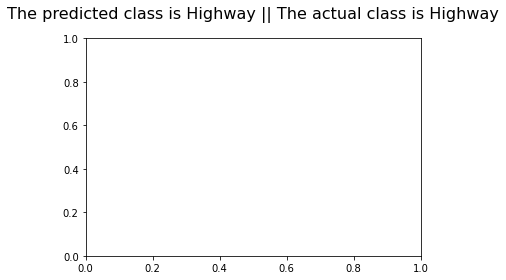

In [ ]:
# plt.figure()
plt.title("The predicted class is "+ class_names[int(predicted_class)] + " || The actual class is "+ class_names[int(y_test[num:n_num])], fontsize=16, pad=20)
plt.savefig('1.svg', bbox_inches='tight', format = 'svg')